# Save ALPAO DMs influence function files to be used in CEO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat

from ceo import wfpt_visulib
from ceo.mapping import Mapping

/home/ubuntu/CEO/python/ceo/zemax


## Read in the ALPAO supplied influence functions

In [2]:
mirror = 'M2'

In [3]:
if mirror == 'M1':
    IFfile = 'BAX449-IF.mat'
elif mirror == 'M2':
    IFfile = 'BAX450-IF.mat'

In [4]:
IFdir = '/home/ubuntu/CEO/python/ceo/wfpt/WFPT_model_data/alpao_dm_ifs'
IFdata = loadmat(os.path.join(IFdir, IFfile))
IF = IFdata['influenceMatrix']
IFmask = IFdata['mask'].T.astype(bool)  # Empirically determined that we need transpose

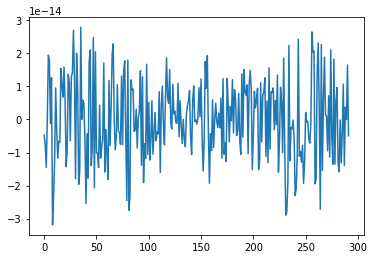

In [5]:
#-- Show non-zero bias offsets
plt.plot(np.mean(IF, axis=1))

In [6]:
nx, ny = IFmask.shape
nacts= IF.shape[0]
IFcube = np.zeros((nacts, nx, ny))

for i in range(len(IFcube)):
    IFcube[i][IFmask] = IF[i] * 1e-6 / 2 # convert to meters surface

### Plot one IF

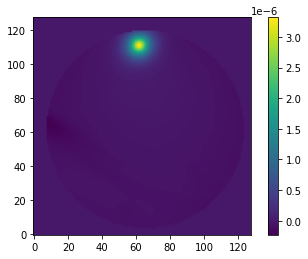

In [7]:
# Plot one example
jj=18
plt.imshow(IFcube[jj] * IFmask, origin='lower')
plt.colorbar()

(-2.306236577362064e-07, 3.321500246492004e-06)

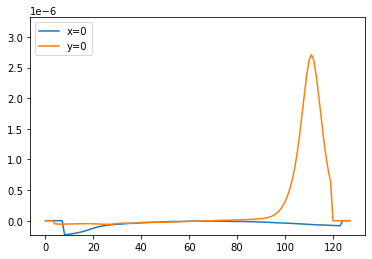

In [8]:
plt.plot(IFcube[jj][nx//2,:], label='x=0')
plt.plot(IFcube[jj][:,ny//2], label='y=0' )
plt.legend()
plt.ylim([IFcube[jj].min(), IFcube[jj].max()])

## Retrieve location of each actuator
Use transformation matrices derived by B. McLeod.

### Retrieve index of actuators
- Recall that (i, j) stands for row and column.
- The equivalent (x, y) coordinates are in fact (j, i).

In [9]:
act_grid = wfpt_visulib.dm292_actmap()
act_i, act_j = np.where(act_grid)

Text(0.5, 1.0, 'index of actuators')

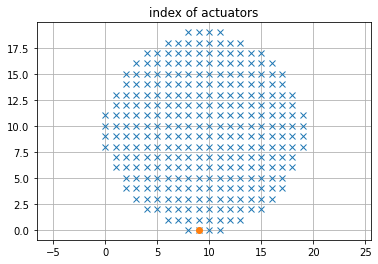

In [10]:
plt.plot(act_j, act_i, 'x')
plt.axis('equal')
plt.grid()

this_act = 1
plt.plot(act_j[this_act], act_i[this_act], 'o')
plt.title('index of actuators')

### Retrieve actuator location in the IF cube
The transformation is designed for the original ALPAO influence function files, which are sampled in a grid of 128$\times$128 pixels.

In [11]:
Tdir = '/home/ubuntu/CEO/python/ceo/wfpt/WFPT_model_data/transformation_matrices'
T = dict(np.load(os.path.join(Tdir,'transforms_D%s.npz'%mirror)))

In [12]:
def apply_transform(transformation_matrix, x_values, y_values):
    x_new = transformation_matrix[0,0] * x_values + transformation_matrix[0,1] * y_values + transformation_matrix[0,2]
    y_new = transformation_matrix[1,0] * x_values + transformation_matrix[1,1] * y_values + transformation_matrix[1,2]
    return x_new, y_new

In [13]:
ij_to_alpao = T['ij_to_alpao']
pj, pi = apply_transform(ij_to_alpao, act_j, act_i)

Text(0.5, 1.0, 'actuator location in IF cube')

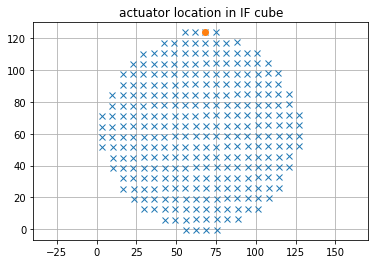

In [14]:
plt.plot(pj, pi, 'x')
plt.axis('equal')
plt.grid()

this_act = 1
plt.plot(pj[this_act], pi[this_act], 'o')
plt.title('actuator location in IF cube')

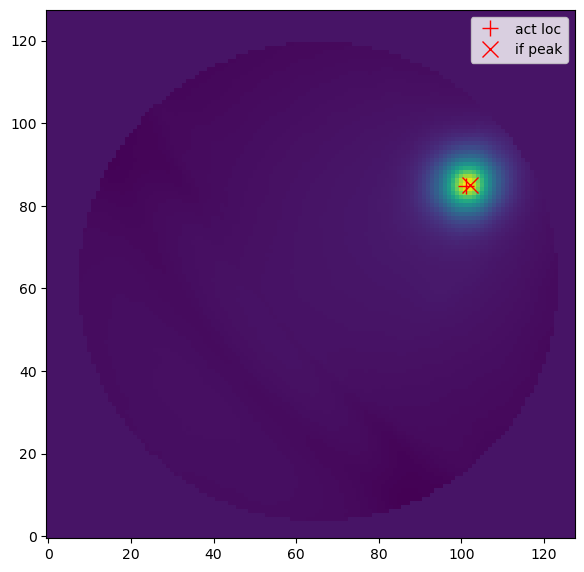

In [16]:
# Plot one example
jj=73
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
fig.dpi=100
xmax, ymax = np.unravel_index(np.argmax(IFcube[jj]), (nx,ny), order='F')
ax.imshow(IFcube[jj] * IFmask, origin='lower')
ax.plot(pj[jj], pi[jj], 'r+', markersize=12, label='act loc')
ax.plot(xmax, ymax, 'rx', markersize=12, label='if peak')
ax.legend()

## Apply mask ontop of each IF
Center the mask ontop of each actuator location, as determined with the transformation above.

### Fermi mask

In [17]:
def fermi_func(r, p1, p2):
    """
    Function to give smoothly tapered mask for DM IF functions. 

    Parameters
    ----------
    r : array_like
        radius variable in units of pixels measured from actuator location. 
    p1 : float
        Parameter controlling how fast the mask declines from 1 to 0.
    p2 : float
        Parameter controlling the width of the mask around an actuator IF.

    Returns
    -------
    ff : array_like
        Function evaluated at r.
    """
    sharp = p1
    pos = -p2/2
    pos2 = p2/2
    y1 = 1/(np.exp(-(r-pos)/sharp) + 1)
    y2 = 1/(np.exp((r-pos2)/sharp) + 1)
    ff = np.multiply(y1,y2)
    ff = np.around(ff,decimals=7)
    
    return ff

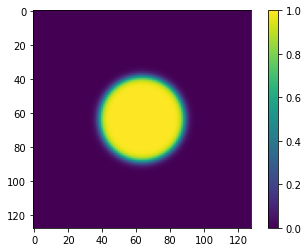

In [18]:
#--- Show example of Fermi mask
x = np.arange(nx) - (nx-1)/2
y = np.arange(ny) - (ny-1)/2
xm, ym = np.meshgrid(x,y)
rm  = np.sqrt(xm**2 + ym**2)
ff_mask = fermi_func(rm, 1.2, 50)
plt.imshow(ff_mask)
plt.colorbar()

### Mask the cube

In [19]:
IFcube_ = np.zeros(IFcube.shape)
for i in range(nacts):
    x = np.arange(nx) - pj[i]
    y = np.arange(ny) - pi[i]
    xm, ym = np.meshgrid(x,y)
    rm  = np.sqrt(xm**2 + ym**2)
    ff_mask = fermi_func(rm, 1.2, 50)
    IFcube_[i] = IFcube[i] * ff_mask * IFmask

Text(0.5, 1.0, 'difference (act#150)')

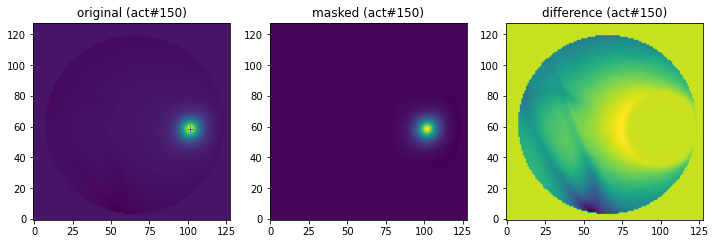

In [20]:
#--- Show an example
jj=150
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)

ax1.imshow(IFcube[jj], origin='lower')
ax1.plot(pj[jj], pi[jj], '+')
ax1.set_title('original (act#%d)'%jj)

ax2.imshow(IFcube_[jj], origin='lower')
ax2.set_title('masked (act#%d)'%jj)

ax3.imshow(IFcube[jj] - IFcube_[jj], origin='lower')
ax3.set_title('difference (act#%d)'%jj)

## Trim the cube
- Trim zero rows and columns; depends on mask, which is slightly different for each device.
- All the final sizes are the same: (292, 116, 116)

In [21]:
if IFfile == 'BAX449-IF.mat':
        _IFcube = IFcube_[:, 4:120, 7:123]
        _IFmask = IFmask[4:120, 7:123]
elif IFfile == 'BAX450-IF.mat':
    _IFcube = IFcube_[:, 4:120, 8:124]
    _IFmask = IFmask[4:120, 8:124]

In [22]:
_IFcube.shape, _IFmask.shape

((292, 116, 116), (116, 116))

Text(0.5, 1.0, 'mask')

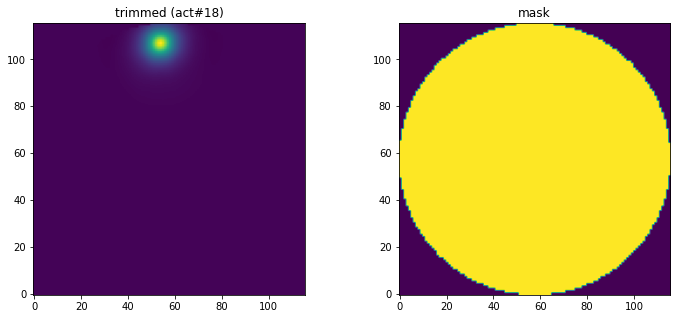

In [25]:
#--- Show an example
jj=18
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

ax1.imshow(_IFcube[jj]*_IFmask, origin='lower')
ax1.set_title('trimmed (act#%d)'%jj)

ax2.imshow(_IFmask, origin='lower')
ax2.set_title('mask')

## Flip the cube
We know how the IF cube needs to be ordered to match the lab orientation (as seen by the SH).
- M1: Flip along the horizontal axis.
- M2: No transformation needed.

In [26]:
if mirror == 'M1':    
    _IFcube = np.flip(_IFcube, axis=1)
    _IFmask = np.flip(_IFmask, axis=0)

Text(0.5, 1.0, 'mask')

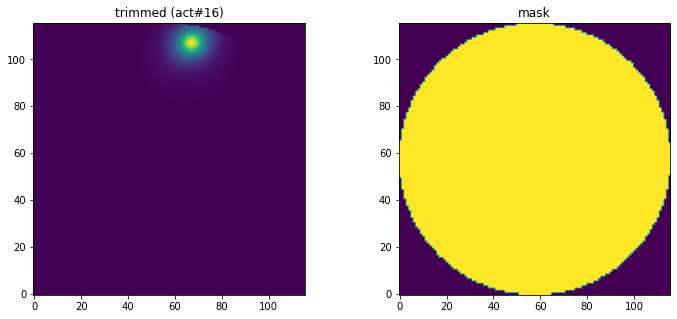

In [27]:
#--- Show an example
jj=16
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

ax1.imshow(_IFcube[jj]*_IFmask, origin='lower')
ax1.set_title('trimmed (act#%d)'%jj)

ax2.imshow(_IFmask, origin='lower')
ax2.set_title('mask')

## Save IFcube in CEO format

In [28]:
D_clear = 26.5e-3 #physical size of DM clear aperture
if mirror == 'M1':
    #D_clear = 0.0257163 # determined from DM-SH48_fine_alignment_v1.ipynb (first iteration)
    D_clear = 0.02583545 #idem: second iteration.
elif mirror == 'M2':
    D_clear = 0.025950687171701774 #(first iteration)
nPx = _IFcube.shape[1]

In [29]:
u = np.linspace(-1, 1, nPx) * D_clear/2
x, y = np.meshgrid(u, u, indexing='ij') #Note: indexing 'ij' required by Mapping
xy = np.vstack([x.ravel(), y.ravel()]).T   
z = _IFcube.reshape(nacts, -1).T
z[~_IFmask.ravel(), :] = np.nan

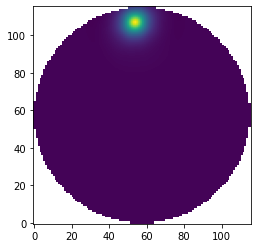

In [30]:
#--- Show an example
jj=18
plt.imshow(z[:,jj].reshape((nPx,nPx)), origin='lower')

In [31]:
infun = Mapping(xy, z)(nPx, D_clear)

# write file with IF cube

CEOfile = IFfile.replace('.mat','')+'_rev2024'
if IFfile == 'BAX449-IF.mat':
    infun.dump(os.path.join(IFdir,CEOfile))
elif IFfile == 'BAX450-IF.mat':
    infun.dump(os.path.join(IFdir,CEOfile))